# Getting data

In [1]:
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import pandas as pd

df = pd.read_csv("../../data/df_notnull_notdup.csv")

sequences, label = df['desc_nonUrl'], df['label']
X_train, X_test, y_train, y_test = train_test_split(sequences, label, stratify=label, 
                                                    test_size=0.2, random_state=42)

print(f'Train size : {len(X_train)}')
print(f'Test  size : {len(X_test)}')

Train size : 10972
Test  size : 2743


# Load the pretrained Tokenizer, Transformer

In [2]:
from transformers import AutoTokenizer, TFAutoModel

checkpoint = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint, output_hidden_states=True)
model.distilbert.trainable = False
clear_output()

# Prepare the data

## Train test split

In [3]:
from sklearn.model_selection import train_test_split

sequences, label = df['desc_nonUrl'], df['label']

X_train, X_test, y_train, y_test = train_test_split(sequences, label, stratify=label, test_size=0.5,
                                                    random_state=42)

print(f'Train size : {len(X_train)}')
print(f'Test  size : {len(X_test)}')

Train size : 6857
Test  size : 6858


In [4]:
datasets = {
    'train': X_train.values.tolist(),
    'test' : X_test.values.tolist()
}
targets = {
    'train': y_train.values.tolist(),
    'test' : y_test.values.tolist()
}

## Tokenization

In [5]:
def tokenize_seqs(seqs):
    encoded = tokenizer(
        seqs,
        padding=True,
        truncation=True,
        return_tensors='tf',
    )
    return encoded.data

In [6]:
tokenized_datasets = {split_ : tokenize_seqs(seqs) for (split_, seqs) in datasets.items()}

In [7]:
tokenized_datasets

{'train': {'input_ids': <tf.Tensor: shape=(6857, 512), dtype=int32, numpy=
  array([[ 101, 1999, 2023, ...,    0,    0,    0],
         [ 101, 2009, 2001, ...,    0,    0,    0],
         [ 101, 2024, 2017, ...,    0,    0,    0],
         ...,
         [ 101, 2161, 1016, ...,    0,    0,    0],
         [ 101, 2206, 1996, ...,    0,    0,    0],
         [ 101, 9765, 2050, ...,    0,    0,    0]], dtype=int32)>,
  'attention_mask': <tf.Tensor: shape=(6857, 512), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>},
 'test': {'input_ids': <tf.Tensor: shape=(6858, 512), dtype=int32, numpy=
  array([[ 101, 2023, 2186, ...,    0,    0,    0],
         [ 101, 2023, 2792, ...,    0,    0,    0],
         [ 101, 3693, 1996, ...,    0,    0,    0],
         ...,
         [ 101, 4918, 1010, ..., 

## Label encoding

In [8]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(targets['train'])
y_test_encoded  = label_encoder.transform(targets['test'])

y_train_ohe = tf.one_hot(y_train_encoded, depth=len(label_encoder.classes_))
y_test_ohe  = tf.one_hot(y_test_encoded, depth=len(label_encoder.classes_))

# Modeling

In [9]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Bidirectional, GRU, Input

def get_model():
    max_seq_length = tokenizer.model_max_length
    n_classes = len(label_encoder.classes_)

    input_ids = Input(shape=(max_seq_length,),dtype='int32')
    attention_mask = Input(shape=(max_seq_length,),dtype='int32')

    transformer_output = model({'input_ids':input_ids, 'attention_mask':attention_mask}, 
                                             training=False)    
    last_hidden_state = transformer_output['last_hidden_state']
    # Model Head
    bi_gru = Bidirectional(GRU(64))(last_hidden_state)
    h1 = tf.keras.layers.Dense(16, activation='relu')(bi_gru)
    dropout = tf.keras.layers.Dropout(0.2)(h1)
    output = tf.keras.layers.Dense(n_classes, activation='softmax')(dropout)

    new_model = tf.keras.models.Model(inputs = [input_ids, attention_mask], 
                                      outputs = output)
    
    new_model.compile(tf.keras.optimizers.Adam(learning_rate=0.003), 
                      loss=CategoricalCrossentropy(from_logits=False), 
                      metrics=['accuracy'])

    return new_model

## Train the model

In [10]:
new_model = get_model()

In [11]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_2[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 128)          320256      tf_distil_bert_model[0][7]   

In [12]:
history = new_model.fit([tokenized_datasets['train']['input_ids'], tokenized_datasets['train']['attention_mask']], 
                          y_train_ohe,
                          validation_split=0.2,
                          epochs=10, batch_size=16)

Epoch 1/10
343/343 [==============================] - 102s 259ms/step - loss: 1.9733 - accuracy: 0.2903 - val_loss: 1.1633 - val_accuracy: 0.6319
Epoch 2/10
343/343 [==============================] - 87s 252ms/step - loss: 1.0094 - accuracy: 0.6729 - val_loss: 0.8235 - val_accuracy: 0.7464
Epoch 3/10
343/343 [==============================] - 87s 253ms/step - loss: 0.6608 - accuracy: 0.7890 - val_loss: 0.7391 - val_accuracy: 0.7879
Epoch 4/10
343/343 [==============================] - 87s 253ms/step - loss: 0.4493 - accuracy: 0.8525 - val_loss: 0.6355 - val_accuracy: 0.8207
Epoch 5/10
343/343 [==============================] - 87s 253ms/step - loss: 0.3407 - accuracy: 0.8881 - val_loss: 0.6771 - val_accuracy: 0.8316
Epoch 6/10
343/343 [==============================] - 87s 253ms/step - loss: 0.2929 - accuracy: 0.9004 - val_loss: 0.7205 - val_accuracy: 0.8200
Epoch 7/10
343/343 [==============================] - 87s 253ms/step - loss: 0.2306 - accuracy: 0.9211 - val_loss: 0.7815 - val_a

In [13]:
from sklearn.metrics import classification_report

y_pred_prob = new_model.predict([tokenized_datasets['test']['input_ids'], tokenized_datasets['test']['attention_mask']])
y_pred = tf.argmax(y_pred_prob, axis=1)

print("Pre-trained")
print(classification_report(y_test_encoded, y_pred.numpy()))

Pre-trained
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       758
           1       0.86      0.88      0.87       674
           2       0.70      0.68      0.69       481
           3       0.94      0.85      0.90       742
           4       0.61      0.78      0.69       591
           5       0.95      0.87      0.91       947
           6       0.84      0.75      0.79       827
           7       0.92      0.71      0.80       518
           8       0.72      0.94      0.82       701
           9       0.92      0.89      0.91       619

    accuracy                           0.82      6858
   macro avg       0.83      0.82      0.82      6858
weighted avg       0.84      0.82      0.82      6858



In [14]:
new_model.save('../../models/fine-tuned-distrilled-bert')

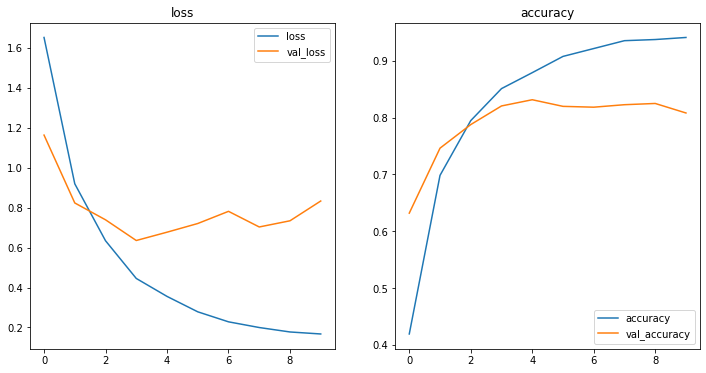

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(12,6))
EPOCHS=10
ax[0].plot(list(range(EPOCHS)), history.history['loss'], label='loss')
ax[0].plot(list(range(EPOCHS)), history.history['val_loss'], label='val_loss')
ax[0].set_title('loss')
ax[0].legend(loc='upper right')

ax[1].plot(list(range(EPOCHS)), history.history['accuracy'], label='accuracy')
ax[1].plot(list(range(EPOCHS)), history.history['val_accuracy'], label='val_accuracy')
ax[1].set_title('accuracy')
ax[1].legend(loc='lower right')
plt.show()